In [1]:
# pip install --upgrade pip
# pip install torch
# pip install torchvision
# pip install pycocotools
# pip faiss-cpu


In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from IPython.display import Image

In [2]:
print(torch.__version__)
print(torchvision.__version__)
print(torchvision.datasets)

2.1.1+cpu
0.16.1+cpu
<module 'torchvision.datasets' from 'c:\\Users\\sobata\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\torchvision\\datasets\\__init__.py'>


In [2]:
base_folder = '../data/data_pic/'
image_folder = base_folder + "pic/"
ann_file = base_folder + "annotations/captions_pic.json"

transform = transforms.Compose([transforms.ToTensor()])
# val_dataset = torchvision.datasets.CocoDetection(
#     root=image_folder,
#     annFile=ann_file,
#     transform=transform
# )
# print(val_dataset)

In [5]:
# _, label = val_dataset[1]
# for l in label:
#     print(l)
# image_file_name = "COCO_val2014_" + str(label[0]["image_id"]).zfill(12) + ".jpg"
# Image(image_folder + image_file_name)

In [7]:
import os
from dotenv import load_dotenv

load_dotenv()

VISION_ENDPOINT = os.getenv('VISION_ENDPOINT')
VISION_API_KEY = os.getenv('VISION_API_KEY')

https://vision-movie.cognitiveservices.azure.com/


In [4]:
import json
import requests
import faiss
import numpy as np

images = []
labels = []
vectors = []
num = 3
def embed_images():
    # 今回はデータセットのうち画像1,000枚をベクトル化
    for i in range(num):
        # label = val_dataset[i]
        # labels.append(label)
        image_file_name = "pic_" + str(i+1) + ".jpg"
        images.append(image_folder + image_file_name)  # 画像ファイルのパス

    endpoint = os.getenv("VISION_ENDPOINT") + "/computervision/retrieval:vectorizeImage?api-version=2023-02-01-preview&modelVersion=latest"
    headers = {
        "Content-Type": "application/octet-stream",  # リクエストボディは画像のバイナリデータ
        "Ocp-Apim-Subscription-Key": os.getenv("API_KEY")
    }

    for idx, image in enumerate(images):
        with open(image, mode="rb") as f:
            image_bin = f.read()
        # Vectorize Image API を使って画像をベクトル化
        response = requests.post(endpoint, headers=headers, data=image_bin)
        # print(response.json())
        image_vec = np.array(response.json()["vector"], dtype="float32").reshape(1, -1)
        vectors.append(image_vec)
    return vectors

vectors = embed_images()

SSLError: HTTPSConnectionPool(host='vision-movie.cognitiveservices.azure.com', port=443): Max retries exceeded with url: //computervision/retrieval:vectorizeImage?api-version=2023-02-01-preview&modelVersion=latest (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:2423)')))

In [6]:
print(vectors)

[array([[ 1.5791016 ,  1.5839844 ,  4.09375   , ...,  0.07373047,
        -0.6640625 ,  0.39672852]], dtype=float32), array([[-3.0175781 ,  0.76904297, -0.8413086 , ..., -0.76904297,
        -2.8515625 , -0.81933594]], dtype=float32), array([[ 1.4482422 ,  0.8769531 , -1.7792969 , ...,  0.08532715,
         1.8466797 ,  2.9511719 ]], dtype=float32)]


In [9]:
# import pickle

# with open("images.pkl", "wb") as f:
#     pickle.dump(images, f)

# with open("labels.pkl", "wb") as f:
#     pickle.dump(labels, f)

# with open("vectors.pkl", "wb") as f:
#     pickle.dump(vectors, f)

In [7]:
def create_index(vectors):
    dimension = 1024
    index_flat_l2 = faiss.IndexFlatL2(dimension)

    for vector in vectors:
        index_flat_l2.add(vector)
    return index_flat_l2

index_flat_l2 = create_index(vectors)

In [8]:

print(index_flat_l2.ntotal)

3


In [9]:
def search_faiss_by_text(query_text, n=3):
    endpoint = os.getenv("VISION_ENDPOINT") + "/computervision/retrieval:vectorizeText?api-version=2023-02-01-preview&modelVersion=latest"
    headers = {
        "Content-Type": "application/json",
        "Ocp-Apim-Subscription-Key": os.getenv("VISION_API_KEY")
    }
    data = {
        "text": query_text
    }
    # Vectorize Text API を使ってクエリをベクトル化
    response = requests.post(endpoint, headers=headers, data=json.dumps(data))
    query_vector = np.array(response.json()["vector"], dtype="float32").reshape(1, -1)
    # Faiss 検索
    D, I = index_flat_l2.search(query_vector, n)
    return D, I

In [10]:
n = 6
D, I = search_faiss_by_text("apple", n)
print(D)
print(images[I[0][0]])

[[8.4537070e+03 8.4609189e+03 8.4643438e+03 3.4028235e+38 3.4028235e+38
  3.4028235e+38]]
../data/data_pic/pic/pic_2.jpg


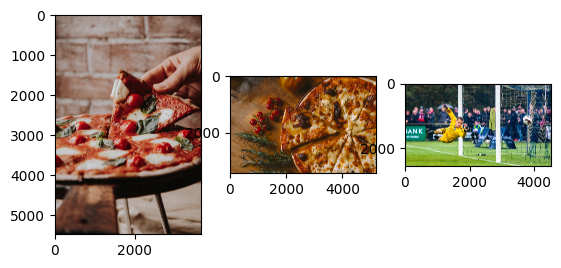

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig = plt.figure()
x = 3
y = 1
for i in range(3):
    ax = fig.add_subplot(y, x, i+1)
    img = mpimg.imread(images[I[0][i]])
    imgplot = plt.imshow(img)
plt.show()

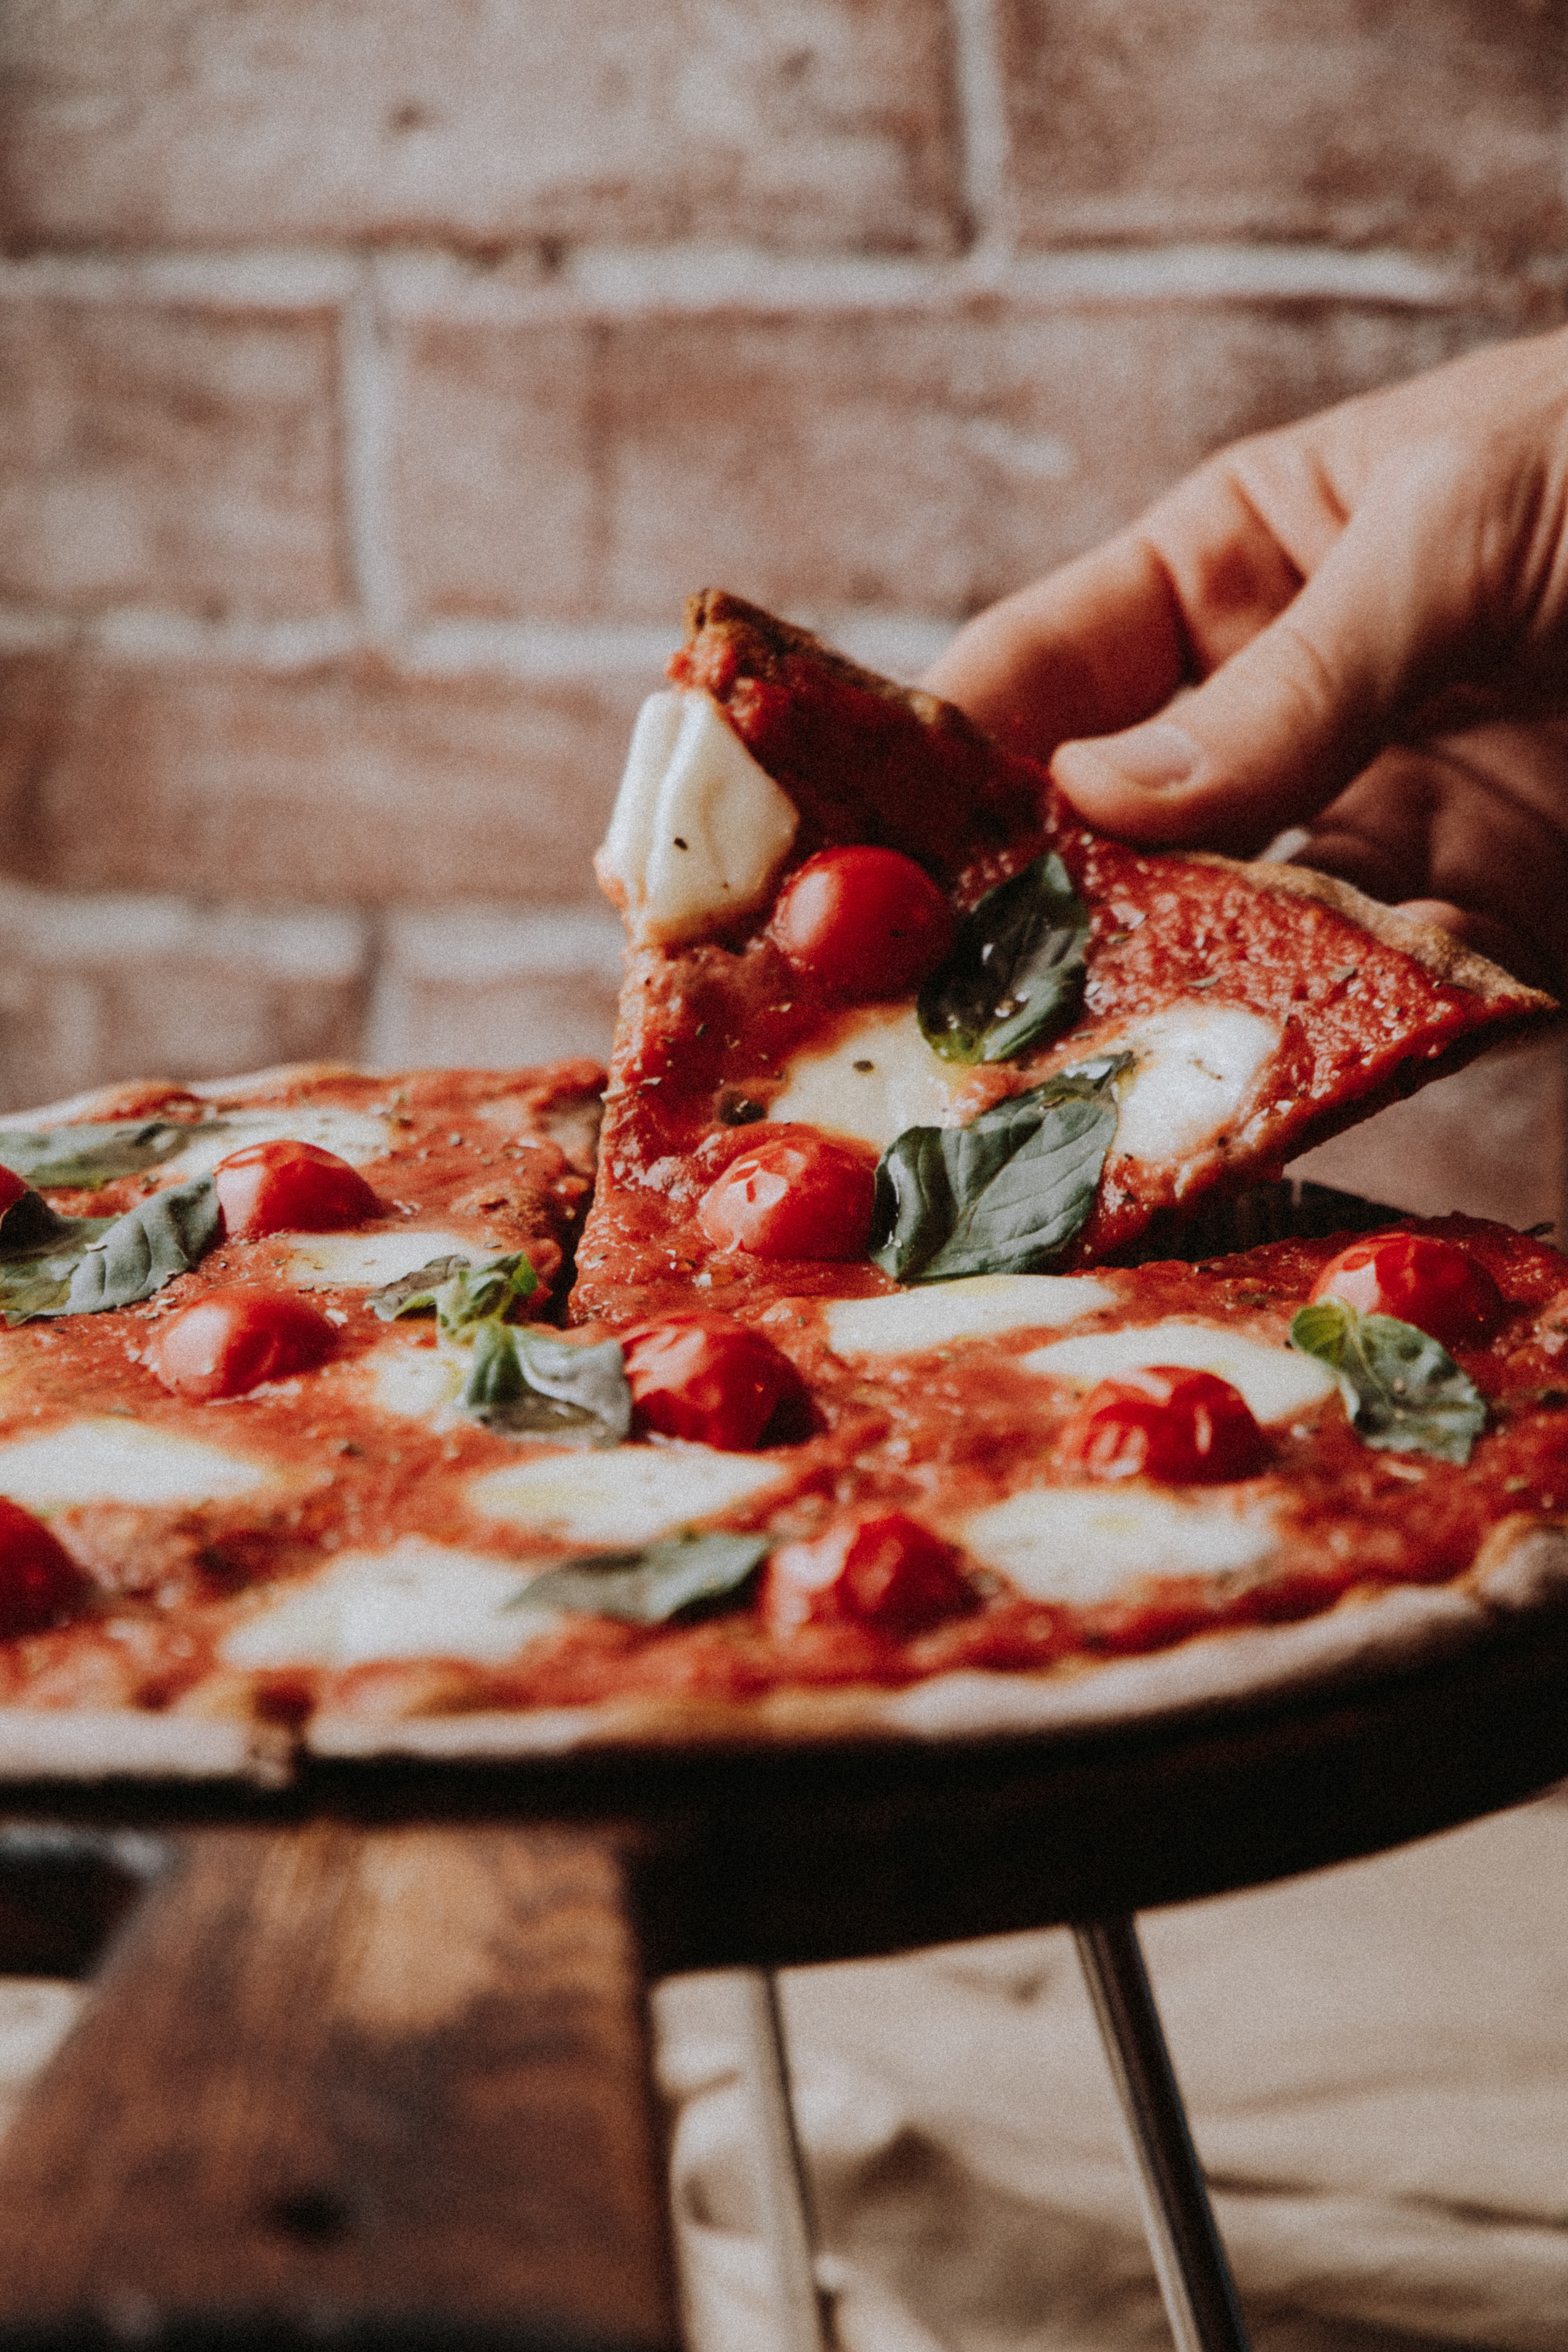

In [ ]:
Image(images[I[0][0]])


In [ ]:
images_files = []
for j in range(20):
    images_files.append(images[I[0][j]])
print(images_files)

IndexError: index 6 is out of bounds for axis 0 with size 6

In [ ]:

range_max = min([len(images_files), 20])
print(range_max)

6


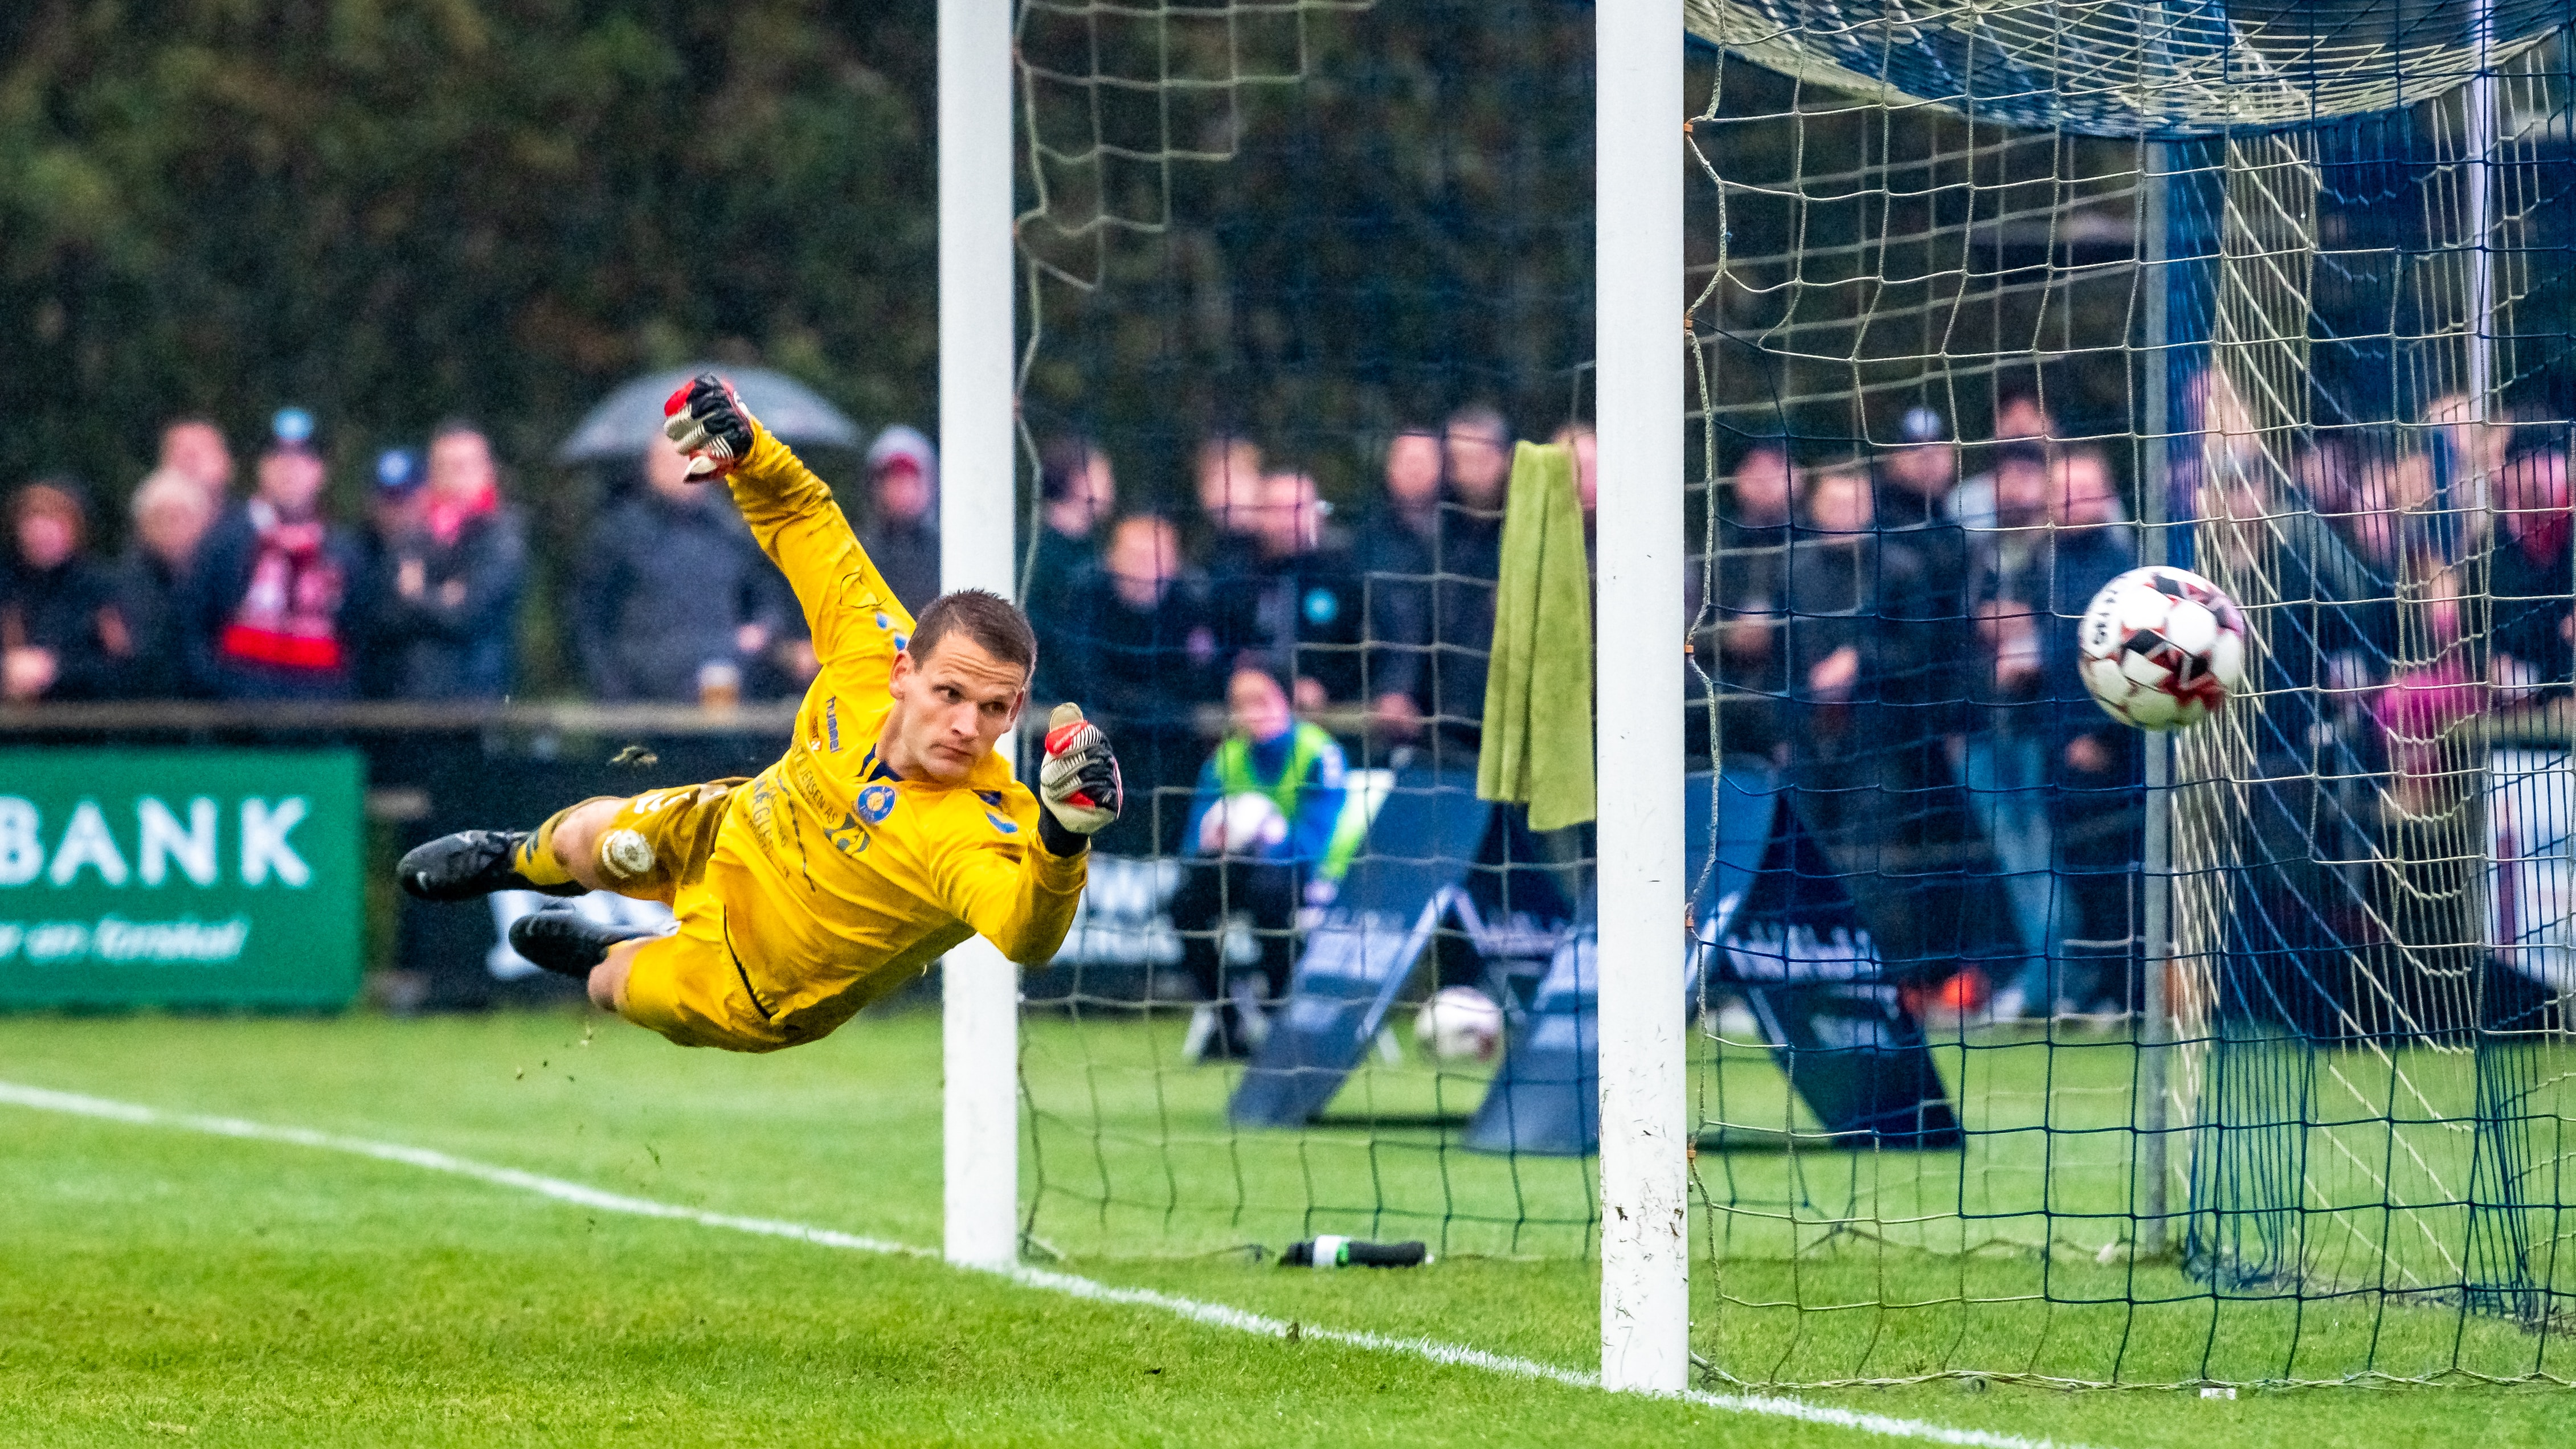

In [ ]:
Image(images[I[0][2]])